In [74]:
import requests
import os 
import datetime

import vertexai
from vertexai.generative_models import GenerativeModel, ChatSession

project_id = "fourth-webbing-420020"
location = "us-central1"
vertexai.init(project=project_id, location=location)
model = GenerativeModel("gemini-1.5-pro-preview-0409")

def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    response = chat.send_message(prompt, stream=False)
    return response.text

In [75]:
with open ('sites.txt') as f:
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]
f.close()

In [76]:
# manual div class keywords
keywords = ["event", "content", "detail", "card", "views","location","time", "date", "notes", "evt"]

# previous 10 years
years = [str(i) for i in range(2010, datetime.datetime.now().year)]

# all monnth in title case
old_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
index_of_month = old_months.index(datetime.datetime.now().strftime("%B"))
old_months = old_months[:index_of_month]

# date fmts
date_fmts = [
    "%b %d, %Y",    # MMM dd, yyyy (e.g., Apr 12, 2024)
    "%B %d, %Y",    # MMMM dd, yyyy (e.g., April 12, 2024)
    "%b %d",        # MMM dd (e.g., Apr 12)
    "%B %d",        # MMMM dd (e.g., April 12)
    "%b %Y",        # MMM yyyy (e.g., Apr 2024)
    "%B %Y",        # MMMM yyyy (e.g., April 2024)
]


# list of sites needing selenium scraping
js_sites = {6:"EventCard_event__kHN5V",7:"card__detail",4:"s-lc-mc-evt",9:"spud913f6613-59b3-4547-ba85-97693a7c9dbb.iframe",1:"trumba.spud.5.iframe"}

### Main Functions


In [77]:

# Custom HTML Parsing as solution vs. LLM Text Extraction w/ HTML Filtering
import bs4
import requests
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

"""
1. Retrieve HTML from a site
1.1 Retrieve HTML from a site using Selenium
2. Extract event text from HTML
2.5 Preprocess Event Text
3. Store event text in a file
4. Convert to JSON or CSV via LLM
5. Store in a database

"""

# 1 - Retrieve HTML from a site
def get_html(site):
    response = requests.get(site)
    if response is None:
        print('Failed to retrieve html from site')
        return None
    return response.text

# 1.1 - Retrieve HTML from a site using Selenium
def get_html_selenium(site, id, site_dict):
    driver = webdriver.Chrome()
    driver.get(site)
    time.sleep(2)
    element = None
    target_element = site_dict[id]
    
    button_element = "//a[text()='WEEK' and @role='button']"
    iframes = driver.find_elements("id",'trumba.spud.3.iframe')
    button_iframe = "trumba.spud.3.iframe"
    
    if len(iframes) > 0:
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.ID, button_iframe)))
        print("Found IFRAME")
        driver.switch_to.frame(button_iframe)
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.XPATH, button_element)))
        print("Found Button")
        element.click()
        time.sleep(2)
        driver.switch_to.default_content()
    
    if ".iframe" in target_element:
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.ID, target_element))
        )
        driver.switch_to.frame(target_element)
        print("Found IFRAME")
        time.sleep(5)
        
    else:
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.CLASS_NAME, target_element))
        )

    html = driver.page_source
    driver.quit()
    return html

# --------------------------------------------------------------------------------------------

# 2 - Extract event text from HTML
def extract_event_text(soup):
    all_divs = soup.find_all('div')
    lowercase_all_divs_classes(all_divs)
    # event_divs = filter_event_divs(all_divs)
    # event_divs = all_divs
    event_text = extract_text_from_event_divs(all_divs)
    event_text = filter_event_text(event_text)
    event_text = retrieve_event_patterns(event_text)
    return event_text

def extract_span_text(soup):
    all_spans = soup.find_all('span')
    lowercase_all_divs_classes(all_spans)
    # event_spans = filter_event_divs(all_spans)
    event_text = extract_text_from_event_divs(all_spans)
    return event_text

# 2.5 - Preprocess Event Text
def lowercase_all_divs_classes(divs):
    for div in divs:
        if div.has_attr('class'):
            div['class'] = [x.lower() for x in div['class']]

# TODO: Validate if this is correct
# ! Does shorten down html file, but sometimes fails to capture everything
# ! Token limit is 32,000 so it is fine for now
# def filter_event_divs(all_divs):
#     event_divs = []
#     for div in all_divs:
#         if div.get('class') is not None and any(keyword in div.get('class')[0] for keyword in keywords):
#             event_divs.append(div)
#     return event_divs

# heuristic filter for after line extraction
# if the 4 lines before and after don't have numbers, it is not an event
def filter_event_text(event_text):
    indexes_to_remove = []

    for index, line in enumerate(event_text):
        if index < 4 or index > len(event_text) - 5:
            continue
        
        if any(char.isdigit() for char in line):
            continue
        
        count = 0
        for i in range(5):
            if any(char.isdigit() for char in event_text[index - i]) or any(char.isdigit() for char in event_text[index + i]):
                break
            count += 1
        if count == 3:
            indexes_to_remove.append(index)
            
    print(indexes_to_remove)
    return [event_text[i] for i in range(len(event_text)) if i not in indexes_to_remove]

# heuristic filter after event number filter
# iterate through the lines add a line only if it is not a duplicate

def retrieve_event_patterns(event_text):
    events = []
    for index, line in enumerate(event_text):
        if line not in events:
            events.append(line)
        
        # checks future events to determine if it is a duplicate
        if any(char.isdigit() for char in line):
            if index < len(event_text) - 1:
                if event_text[index + 1] not in events:
                    events.append(event_text[index + 1])
    return events
    

def extract_text_from_event_divs(event_divs):
    event_text = []
    for div in event_divs:
        text = div.get_text()
        text = [x for x in text.split('\n') if x != '']
        for line in text:
            if is_old_event(line):
                continue
            while '\n' in line:
                line = line.replace('\n', ' ')
            event_text.append(line + '\n')
    return event_text

def is_old_event(line):
    if any(year in line for year in years):
        return True
    elif any(month in line for month in old_months):
        return True
    return False

def remove_duplicates(event_text):
    return list(set(event_text))

# --------------------------------------------------------------------------------------------


# 3 - Store event text in a file
def write_event_text(event_text, filename):
    event_text = [x.encode('ascii', 'ignore').decode('ascii') for x in event_text]
    folder = "extracted_txt"
    file_path = folder + "/" + filename
    with open(file_path, 'w') as f:
        for event in event_text:
            if len(event) > 0 or event != ' ':
                f.write(event)
    f.close()
    return 0

def test_write_event_text(event_text, filename):
    event_text = [x.encode('ascii', 'ignore').decode('ascii') for x in event_text]
    print(f"After Removing Duplicates {len(event_text)}")
    folder = "test_extractions_txt"
    file_path = folder + "/" + filename
    with open(file_path, 'w') as f:
        for event in event_text:
            if len(event) > 0 or event != ' ':
                f.write(event)
    f.close()
    return 0
# --------------------------------------------------------------------------------------------

# 4 - Convert to JSON or CSV via LLM
def convert_to_json(site_index):
    input_text = """ 
    Convert this text to JSON for events with this schema:
    Event:
    - Title: The name of the event 
    - Start Time: Has to be 1 value
    - End Time: Has to be 1 value
    - Date: Month, Day of the event 
    - Location: Where the event takes place 
    
    Numbers like 911am should be split to start and end times
    Nulls should be null
    """
    filename = f'site_{site_index}.txt'
    with open(f'extracted_txt/{filename}') as f:
        site_text = f.read()
    input_text += site_text
    
    chat = model.start_chat()
    response = get_chat_response(chat, input_text)
    
    output = response
    while "`" in output:
        output = output.replace("`", "")
    output = output.replace("JSON", "")
    output = output.replace("json", "")
    
    with open(f'event_jsons/site_{site_index}.json', 'w') as f:
        f.write(output)
    f.close()
    
    return 0

# --------------------------------------------------------------------------------------------

# 5 - Read JSON and store in a database
def read_json(site_index):
    with open(f'event_jsons/site_{site_index}.json') as f:
        event_json = f.read()
    f.close()
    return event_json

# X - Store as a CSV for now

# --------------------------------------------------------------------------------------------


def single_site(site):
    html = get_html(site)
    print(html)
    soup = bs4.BeautifulSoup(html, 'html.parser')
    event_text = extract_event_text(soup)
    write_event_text(event_text, 'site.txt')
    convert_to_json(1)
    print(len(event_text))
    print(event_text)
    return 0

def single_site_js(site, id, site_dict):
    html = get_html_selenium(site, id, site_dict)
    print(html)
    soup = bs4.BeautifulSoup(html, 'html.parser')
    event_text = extract_event_text(soup)
    write_event_text(event_text, 'site.txt')
    convert_to_json(1)  
    print(len(event_text))
    print(event_text)
    return 0

def process_sites():
    for i, site in enumerate(lines):
        print(f"Processing site {site}")

        if i in js_sites:
            html = get_html_selenium(site, i, js_sites)
        else:
            html = get_html(site)

        soup = bs4.BeautifulSoup(html, 'html.parser')
        event_text = extract_event_text(soup)
        write_event_text(event_text, f'site_{i}.txt')
        convert_to_json(i)

        print(f"Finished processing site {i}")
        # # gemini pro free can only process 2 requests per minute
        # time.sleep(30)
    return 0

In [78]:
process_sites()

Processing site https://scholarslab.lib.virginia.edu/events/
[70, 158, 168, 175, 194]


Finished processing site 0
Processing site https://www.virginia.edu/calendar
Found IFRAME
Found Button
Found IFRAME
[]
Finished processing site 1
Processing site https://education.virginia.edu/events
[60, 68, 78, 79, 85, 86, 93, 97, 103, 110, 113, 125, 128, 140, 143, 155, 160, 172, 175, 187, 188, 194, 195, 202, 205, 217, 221, 231, 251, 258, 276, 282, 341, 349, 359, 360, 366, 367, 374, 378, 384, 391, 394, 406, 409, 421, 424, 436, 441, 453, 456, 468, 469, 475, 476, 483, 486, 498, 502, 512, 532, 539, 557, 563, 734, 742, 752, 753, 759, 760, 767, 771, 777, 784, 787, 799, 802, 814, 817, 829, 834, 846, 849, 861, 862, 868, 869, 876, 879, 891, 895, 905, 921, 929, 939, 940, 946, 947, 954, 958, 964, 971, 974, 986, 989, 1001, 1004, 1016, 1021, 1033, 1036, 1048, 1049, 1055, 1056, 1063, 1066, 1078, 1082, 1092, 1099, 1107, 1117, 1118, 1124, 1125, 1132, 1136, 1142, 1149, 1152, 1164, 1167, 1179, 1182, 1194, 1199, 1211, 1214, 1226, 1227, 1233, 1234, 1241, 1244, 1256, 1260, 1270, 1299, 1308, 1318, 1319, 

0

### Json Playground

In [79]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
def update_year(value):
    if pd.isna(value):
        return value
    return value.replace(year=2024)

def convert_to_datetime(value):
    new_value = value
    
    if pd.isna(value) or isinstance(value, pd.Timestamp):
        return value
    
    while "." in new_value:
        new_value = new_value.replace('.', '')
        
    for fmt in ('%I:%M%p', '%I:%M %p', '%I%p', '%I %p'):
        try:
            return pd.to_datetime(new_value, format=fmt)
        except ValueError:
            pass
    return new_value

def convert_to_date(value):
    new_value = value
    
    if pd.isna(value) or isinstance(value, pd.Timestamp):
        return value
    
    while "." in new_value:
        new_value = new_value.replace('.', '')
        
    for fmt in date_fmts:
        try:
            return pd.to_datetime(new_value, format=fmt)
        except ValueError:
            pass

def edit_time(value):
    if pd.isna(value) or isinstance(value, pd.Timestamp):
        return value
    try:
        times = str.split(value, ':')
        hour = int(times[0])
        if hour > 12:
            hour -= 12
            return str(hour) + ':' + times[1] + ' pm'
        if hour < 10:
            return value + ' pm'
        else:
            return value + ' am'
    except:
        print(f"Failed to convert time {value}")
        return value

In [81]:
listdir_names_list = os.listdir('event_jsons')

In [82]:
all_events = []
event_dfs = []
nan_dfs = []
discard_dfs = []

with open('sites.json') as f:
    site_dict = json.load(f)
f.close()

for id, site_meta in enumerate(site_dict):
    file = f'site_{id}.json'
    with open(f'event_jsons/{file}') as f:
        text = json.load(f)
    f.close()

    for event in text:
        event["Department"] = site_meta["department"]
        event["Site"] = site_meta["site"]
        all_events.append(event)
        
    df = pd.DataFrame(text)
    nan_df = df[df["Date"].isna()]
    df["Date"] = df["Date"].apply(convert_to_date).apply(update_year)
    discard_df = df[df["Date"] < datetime.datetime.now()]
    df = df[df["Date"] >= datetime.datetime.now()]
    df["Start Time"] = df["Start Time"].apply(convert_to_datetime).apply(edit_time).apply(convert_to_datetime)
    df["End Time"] = df["End Time"].apply(convert_to_datetime).apply(edit_time).apply(convert_to_datetime)
    df.drop_duplicates(subset=['Title'], inplace=True)
    event_dfs.append(df)
    nan_dfs.append(nan_df)
    discard_dfs.append(discard_df)

In [83]:
# List Potential N/A Values in a list
na_words = ["None", "N/A"]
all_events_df = pd.concat(event_dfs)
for na_word in na_words:
    print(f"Replacing {na_word}")
    all_events_df.replace(na_word, pd.NA, inplace=True)
all_events_df.reset_index(drop=True, inplace=True)

all_events_time_nan_df = all_events_df[all_events_df["Start Time"].isna() & all_events_df["End Time"].isna()]
nan_df = pd.concat(nan_dfs)
nan_df = pd.concat([nan_df, all_events_time_nan_df])
nan_df.reset_index(drop=True, inplace=True)

discard_df = pd.concat(discard_dfs)
discard_df.reset_index(drop=True, inplace=True)

all_events_df.dropna(subset=['Start Time', 'End Time'], inplace=True)

print(f'Total Events {nan_df.shape[0] + all_events_df.shape[0]}')
print(f'Discarded Events {discard_df.shape[0]}')

Replacing None
Replacing N/A
Total Events 91
Discarded Events 34


In [84]:
missing_end_time_rows = all_events_df["End Time"].isna()
new_end_time_values = all_events_df.loc[missing_end_time_rows, "Start Time"] - datetime.timedelta(hours=1)
all_events_df.loc[missing_end_time_rows, "End Time"] = new_end_time_values

# set both start and etime column dtypes to dt
all_events_df["Start Time"] = pd.to_datetime(all_events_df["Start Time"])
all_events_df["End Time"] = pd.to_datetime(all_events_df["End Time"])

all_events_df["Start Time"] = all_events_df["Start Time"].dt.strftime('%I:%M %p')
all_events_df["End Time"] = all_events_df["End Time"].dt.strftime('%I:%M %p')

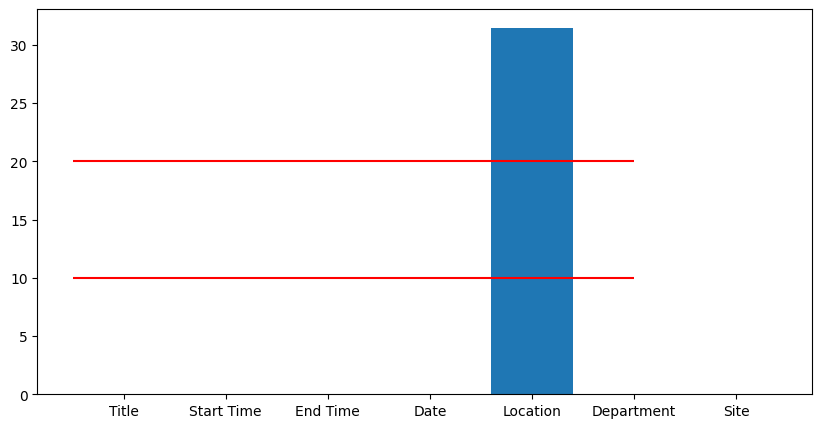

In [85]:
# sum isna
isna = all_events_df.isna().sum()
rows = all_events_df.shape[0]
isna_percent = isna / rows * 100
plt.figure(figsize=(10, 5))
plt.bar(isna_percent.index, isna_percent)
plt.hlines(20, -.5, 5, colors='r')
plt.hlines(10, -.5, 5, colors='r')

In [94]:
nan_with_date_df = all_events_df[all_events_df["Date"].isna()]
nan_with_date_df 

,Title,Start Time,End Time,Date,Location,Department,Site


In [86]:
nan_with_date_df = all_events_df[all_events_df["Date"].isna()]

nan_with_date_df.reset_index(drop=True, inplace=True)
all_events_df.reset_index(drop=True, inplace=True)
nan_with_date_df.reset_index(drop=True, inplace=True)

In [87]:
all_events_df.to_csv('allevents_csv/all_events.csv', index=False)
nan_df.to_csv('allevents_csv/nan_events.csv', index=False)
nan_with_date_df.to_csv('allevents_csv/nan_with_date_events.csv', index=False)

### LLM Playground

In [88]:

# TODO(developer): Update and un-comment below lines
project_id = "fourth-webbing-420020"
location = "us-central1"
vertexai.init(project=project_id, location=location)
model = GenerativeModel("gemini-1.0-pro")
chat = model.start_chat()

def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    responses = chat.send_message(prompt, stream=True)
    for chunk in responses:
        text_response.append(chunk.text)
    return "".join(text_response)

prompt = "Hello."
print(get_chat_response(chat, prompt))

prompt = "What are all the colors in a rainbow?"
print(get_chat_response(chat, prompt))

prompt = "Why does it appear when it rains?"
print(get_chat_response(chat, prompt))

Hello there! How can I help you today? I'm an artificial intelligence assistant, and I'm here to help you with any questions you may have.
The colors in a rainbow are:

1. Red
2. Orange
3. Yellow
4. Green
5. Blue
6. Indigo
7. Violet

These colors are often remembered using the acronym ROYGBIV.
Rainbows appear when sunlight interacts with raindrops in the atmosphere. When sunlight hits a raindrop, it is refracted, or bent. The different colors of light are refracted at different angles, causing them to separate. This separation of colors is what we see as a rainbow.

For a rainbow to form, the sun must be behind the observer and the rain must be in front of the observer. The sun's rays must also be able to reach the raindrops at a specific angle. This is why rainbows are most often seen in the sky opposite the sun, and why they are usually arc-shaped.

The size and shape of a rainbow depends on the size of the raindrops and the angle of the sun's rays. Smaller raindrops produce smaller 

In [89]:
input_text = """ 
    Convert this text to JSON for events with this schema:
    Event:
    - Title: The name of the event 
    - Start Time: Has to be 1 value
    - End Time: Has to be 1 value
    - Date: (Month, Day) of the event 
    - Location: Where the event takes place 
    
    Store the objects in a JSON array without duplicate entries.
    Close numbers like 911am should be split to 9am and 11am.
    Exclude '''JSON''' in the text.
"""

# print the length of input text after being added upon for each site text
cost_per_1000 = 0.000125
total_cost = 0
for i in range(len(lines)):
    with open(f'extracted_txt/site_{i}.txt') as f:
        site_text = f.read()
    f.close()
    site_text += input_text
    input_length = len(site_text)
    print(f"Site {i} Length: {len(site_text)}")
    print(f"Cost: ${cost_per_1000 * (input_length / 1000)}")
    total_cost += cost_per_1000 * (input_length / 1000)
print(f"Total Cost: ${total_cost}")

Site 0 Length: 1447
Cost: $0.00018087500000000002
Site 1 Length: 17244
Cost: $0.0021555
Site 2 Length: 6100
Cost: $0.0007624999999999999
Site 3 Length: 3446
Cost: $0.00043075000000000003
Site 4 Length: 11940
Cost: $0.0014925
Site 5 Length: 7065
Cost: $0.0008831250000000001
Site 6 Length: 12682
Cost: $0.00158525
Site 7 Length: 3706
Cost: $0.00046325
Site 8 Length: 9186
Cost: $0.00114825
Site 9 Length: 4456
Cost: $0.0005570000000000001
Site 10 Length: 6566
Cost: $0.00082075
Site 11 Length: 7645
Cost: $0.000955625
Total Cost: $0.011435375000000001


### Test Functions

In [90]:
import unittest

class TestEventExtraction(unittest.TestCase):
    def setUp(self):
        self.html = """
        <html>
            <body>
                <div class="event">Event 1</div>
                <div class="content">Content 1</div>
                <div class="detail">Detail 1</div>
                <div class="card">Card
                <div class="views">Views 1</div>
                <div class="location">Location 1</div>
        </html>
        """
        self.soup = bs4.BeautifulSoup(self.html, 'html.parser')
        self.all_divs = self.soup.find_all('div')
    
    def test_lowercase_all_divs_classes(self):
        lowercase_all_divs_classes(self.all_divs)
        for div in self.all_divs:
            if div.has_attr('class'):
                self.assertTrue(all(x.islower() for x in div['class']))
    
    def test_filter_event_divs(self):
        event_divs = filter_event_divs(self.all_divs)
        self.assertTrue(all(any(keyword in div.get('class')[0] for keyword in keywords) for div in event_divs))
    
    def test_is_old_event(self):
        old_event = "Event from 2010"
        self.assertTrue(is_old_event(old_event))
                
    def test_extract_html(self):
        site = 'https://www.google.com'
        html = get_html(site)
        self.assertIsNotNone(html)
        
    def test_extract_selenium_html(self):
        site = 'https://www.virginia.edu/calendar'
        id = 1
        site_dict = {4:"s-lc-mc-evt",9:"spud913f6613-59b3-4547-ba85-97693a7c9dbb.iframe",1:"trumba.spud.5.iframe"}
        html = get_html_selenium(site, id, site_dict)
        self.assertIsNotNone(html)
                
    
    
unittest.main(argv=[''], exit=False)

.

Found IFRAME
Found Button
Found IFRAME


.E..
ERROR: test_filter_event_divs (__main__.TestEventExtraction.test_filter_event_divs)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\commo\AppData\Local\Temp\ipykernel_32948\2480613337.py", line 26, in test_filter_event_divs
    event_divs = filter_event_divs(self.all_divs)
                 ^^^^^^^^^^^^^^^^^
NameError: name 'filter_event_divs' is not defined

----------------------------------------------------------------------
Ran 5 tests in 19.941s

FAILED (errors=1)


In [91]:
def test_parsings(sites):
    for id, site in enumerate(sites):
        if id in js_sites:
            html = get_html_selenium(site, id, js_sites)
        else:
            html = get_html(site)
        soup = bs4.BeautifulSoup(html, 'html.parser')
        event_text = extract_event_text(soup)
        test_write_event_text(event_text, f'site_{id}.txt')
        print(len(event_text), site)
        
    return 0 

In [92]:
# test list_set for the extracted_txt files
for i in range(len(lines)):
    with open(f'test_extractions_txt/site_{i}.txt') as f:
        site_text = f.read()
    f.close()
    site_text = site_text.split('\n')
    site_text = retrieve_event_patterns(site_text)
    site_text = "\n".join(site_text)
    print(f"Site {i} Length: {len(site_text)}")
    write_event_text(site_text, f'site_{i}.txt')

Site 0 Length: 1017
Site 1 Length: 16813
Site 2 Length: 5670
Site 3 Length: 3015
Site 4 Length: 11510
Site 5 Length: 6632
Site 6 Length: 12252
Site 7 Length: 3276
Site 8 Length: 8820
Site 9 Length: 4025
Site 10 Length: 6134
Site 11 Length: 7214


In [93]:
test_parsings(lines)

[70, 158, 168, 175, 194]
After Removing Duplicates 50
50 https://scholarslab.lib.virginia.edu/events/
Found IFRAME
Found Button
Found IFRAME
[]
After Removing Duplicates 120
120 https://www.virginia.edu/calendar
[60, 68, 78, 79, 85, 86, 93, 97, 103, 110, 113, 125, 128, 140, 143, 155, 160, 172, 175, 187, 188, 194, 195, 202, 205, 217, 221, 231, 251, 258, 276, 282, 341, 349, 359, 360, 366, 367, 374, 378, 384, 391, 394, 406, 409, 421, 424, 436, 441, 453, 456, 468, 469, 475, 476, 483, 486, 498, 502, 512, 532, 539, 557, 563, 734, 742, 752, 753, 759, 760, 767, 771, 777, 784, 787, 799, 802, 814, 817, 829, 834, 846, 849, 861, 862, 868, 869, 876, 879, 891, 895, 905, 921, 929, 939, 940, 946, 947, 954, 958, 964, 971, 974, 986, 989, 1001, 1004, 1016, 1021, 1033, 1036, 1048, 1049, 1055, 1056, 1063, 1066, 1078, 1082, 1092, 1099, 1107, 1117, 1118, 1124, 1125, 1132, 1136, 1142, 1149, 1152, 1164, 1167, 1179, 1182, 1194, 1199, 1211, 1214, 1226, 1227, 1233, 1234, 1241, 1244, 1256, 1260, 1270, 1299, 1308, 

0